<a href="https://colab.research.google.com/github/hypo69/hypotez/blob/master/src/llm/gemini/Gemini_API_Model_tuning_with_Python_local_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Gemini API: Model tuning with Python

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemini-api/docs/model-tuning/python"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  </td>
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/model-tuning/python.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/model-tuning/python.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this notebook, you'll learn how to get started with the tuning service using the Python client library for the Gemini API. Here, you'll learn how to tune the text model behind the Gemini API's text generation service.

## Setup

### Install the client library

In [ ]:
!pip install -q google-generativeai

### Import libraries

In [ ]:
import google.generativeai as genai

In [ ]:
from google.colab import userdata
#genai.configure(api_key=userdata.get('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')) # onela
genai.configure(api_key='....') # onela

You can check you existing tuned models with the `genai.list_tuned_model` method.

In [ ]:
for i, m in zip(range(5), genai.list_tuned_models()):
  print(m.name)

## Create tuned model

To create a tuned model, you need to pass your dataset to the model in the `genai.create_tuned_model` method. You can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

For this example, you will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

In [ ]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods and
    "flash" in m.name][0]
base_model

Model(name='models/gemini-1.5-flash-001-tuning',
      base_model_id='',
      version='001',
      display_name='Gemini 1.5 Flash 001 Tuning',
      description=('Version of Gemini 1.5 Flash that supports tuning, our fast and versatile '
                   'multimodal model for scaling across diverse tasks, released in May of 2024.'),
      input_token_limit=16384,
      output_token_limit=8192,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=1.0,
      max_temperature=2.0,
      top_p=0.95,
      top_k=64)

In [23]:
import random

name = f'generate-num-{random.randint(0,10000)}'
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    # source_model=base_model.name,
    source_model = 'models/gemini-1.5-flash-001-tuning',
    training_data=[
       {
    "text_input": "Here's a thinking process for refactoring `run_task_on_active_models`:\n\n1.  **Understand the Goal:** The request is to simplify the `run_task_on_active_models` function by breaking it down into smaller, more focused functions. Specifically, the goal is to separate the logic for *identifying and initializing* active models from the logic of *running the task* using those initialized models.\n\n2.  **Analyze the Current `run_task_on_active_models`:**\n    *   **Input:** `app_config` (contains `models_to_use` dict), `task` (string).\n    *   **Output:** `Optional[Dict[str, Optional[str]]]` (results per model provider).\n    *   **Steps:**\n        *   Validate `app_config.models_to_use`.\n        *   Initialize `results` dictionary and flags (`active_model_found`, `active_models_to_run`).\n        *   **First Loop:** Iterate through `models_to_use` to identify active models (`status == 'active'`) and store their keys in `active_models_to_run`.\n        *   Check if any active models were found. If not, log an error and return `None`.\n        *   Log the list of active models.\n        *   **Second Loop:** Iterate through `models_to_use` *again*.\n        *   Skip inactive models (check against `active_models_to_run`).\n        *   Check if `model_name` exists.\n        *   **Initialization Logic:**\n            *   Use `if/elif/else` based on `provider_key` (`gemini`, `openai`, etc.).\n            *   Get the API key from `os.getenv`.\n            *   Check if the key exists.\n            *   If key exists, instantiate the corresponding `Chat...` class (`ChatGoogleGenerativeAI` or `ChatOpenAI`).\n            *   Set `model_initialized` flag.\n            *   Log success/failure of initialization.\n            *   Handle unknown providers.\n            *   Handle exceptions during initialization.\n        *   **Task Execution Logic:**\n            *   If `model_initialized` is true and `llm_instance` is not `None`:\n                *   Call `await _run_agent_task(llm_instance, task)`.\n                *   Store the result in the `results` dictionary.\n            *   Else (initialization failed):\n                *   Store `None` in the `results` dictionary.\n                *   Log a warning.\n        *   Return the `results` dictionary.\n\n3.  **Identify Areas for Separation:**\n    *   The first loop and the initial checks (finding active models) seem like a distinct responsibility: \"Get Active Model Configurations\".\n    *   The second loop combines *initialization* and *execution*. The initialization part (getting keys, creating LLM instances) can be separated.\n    *   The execution part (calling `_run_agent_task` for each successfully initialized model) is another distinct step.\n\n4.  **Design New Functions:**\n\n    *   **`_get_active_model_configs(app_config: Config) -> Dict[str, Dict[str, str]]`:**\n        *   Takes `app_config`.\n        *   Iterates through `app_config.models_to_use`.\n        *   Filters for `status == 'active'`.\n        *   Returns a *new dictionary* containing only the configurations of active models (provider key -> model details dict).\n        *   Handles the case where `models_to_use` is invalid or no active models are found (maybe return an empty dict or raise an error? Returning an empty dict seems simpler for the caller).\n\n    *   **`_initialize_llm(provider_key: str, model_details: Dict[str, str]) -> Optional[BaseChatModel]`:**\n        *   Takes the `provider_key` (e.g., 'gemini') and its `model_details` dictionary.\n        *   Checks for `model_name`.\n        *   Gets the correct API key using `os.getenv` based on `provider_key`.\n        *   Checks if the key exists.\n        *   Instantiates the appropriate `Chat...` class.\n        *   Handles initialization errors (log and return `None`).\n        *   Handles unknown providers (log and return `None`).\n        *   Returns the initialized `BaseChatModel` instance or `None` if initialization fails.\n\n    *   **Revised `run_task_on_active_models(app_config: Config, task: str) -> Optional[Dict[str, Optional[str]]]`:**\n        *   Call `_get_active_model_configs`.\n        *   If the result is empty, log and return `None`.\n        *   Create an empty `results` dictionary.\n        *   Create a list of tasks to run concurrently using `asyncio.gather`.\n        *   **Loop** through the *active model configs*:\n            *   Call `_initialize_llm` for the current model config.\n            *   If initialization is successful (`llm_instance` is not `None`):\n                *   Create a coroutine: `_run_agent_task(llm_instance, task)`.\n                *   Store this coroutine along with the `provider_key` (maybe in a list of tuples `(provider_key, coroutine)`).\n            *   If initialization fails:\n                *   Add the `provider_key` with a `None` result directly to the `results` dictionary.\n        *   Use `asyncio.gather` to run all the created agent task coroutines concurrently.\n        *   Process the results from `asyncio.gather`, matching them back to their `provider_key` and adding them to the `results` dictionary.\n        *   Return the final `results` dictionary.\n\n5.  **Refine the Design:**\n    *   Using `asyncio.gather` is good for concurrency. We need to map the results back. Instead of a separate list of tuples, maybe create the coroutines and then run them?\n    *   Let's simplify the flow within the revised `run_task_on_active_models`:\n        1.  Get active configs using `_get_active_model_configs`.\n        2.  If empty, return `None`.\n        3.  Initialize `tasks_to_run = []` and `results = {}`.\n        4.  Iterate through active configs:\n            *   Try initializing using `_initialize_llm`.\n            *   If successful, add `(provider_key, _run_agent_task(llm, task))` to `tasks_to_run`.\n            *   If failed, add `results[provider_key] = None`.\n        5.  Extract just the coroutines: `coroutines = [t[1] for t in tasks_to_run]`.\n        6.  Run `gathered_results = await asyncio.gather(*coroutines, return_exceptions=True)`. Using `return_exceptions=True` is safer.\n        7.  Iterate through `tasks_to_run` and `gathered_results` together (using `zip` or index):\n            *   Get the `provider_key` from `tasks_to_run`.\n            *   Get the corresponding result/exception from `gathered_results`.\n            *   If it's an exception, log it and set `results[provider_key] = None`.\n            *   If it's a valid result, set `results[provider_key] = result`.\n        8.  Return `results`.\n\n6.  **Implement the Code:** Write the Python code for the new functions (`_get_active_model_configs`, `_initialize_llm`) and the refactored `run_task_on_active_models` based on the refined design. Add necessary logging and type hints.\n\n7.  **Test (Mentally or Actually):**\n    *   What if `models_to_use` is empty or invalid? `_get_active_model_configs` should handle it, `run_task_on_active_models` should return `None`.\n    *   What if no models are active? `_get_active_model_configs` returns empty, `run_task_on_active_models` returns `None`.\n    *   What if an API key is missing? `_initialize_llm` should return `None`, and `run_task_on_active_models` should record `None` for that provider.\n    *   What if LLM initialization throws an unexpected error? `_initialize_llm` should catch it, log, return `None`.\n    *   What if `_run_agent_task` throws an error? `asyncio.gather(return_exceptions=True)` will catch it, and the final loop in `run_task_on_active_models` will handle the exception, logging it and setting the result to `None`.\n    *   What if one model succeeds and another fails initialization? The results dictionary should reflect this correctly.\n    *   What if one model succeeds and another fails during execution? The results dictionary should reflect this correctly.\n\n8.  **Review and Document:** Add docstrings to the new functions explaining their purpose, arguments, and return values. Ensure logging is clear and helpful. Update the docstring for `run_task_on_active_models` to reflect the changes. Make sure imports and type hints are correct. Ensure the original functionality is preserved.",
    "output": "Loop:** Iterate through `models_to_use` to identify active models (`status == 'active'`) and store their keys in `active_models_to_run`. * Check if any active models were found. If not, log an error and return `None`. * Log the list of active models. * **Second Loop:** Iterate through `models_to_use` *again*. * Skip inactive models (check against `active_models_to_run`). * Check if `model_name` exists. * **Initialization Logic:** * Use `if/elif/else` based on `provider_key` (`gemini`, `openai`, etc.). * Get the API key from `os.getenv`. * Check if the key exists. * If key exists, instantiate the corresponding `Chat...` class (`ChatGoogleGenerativeAI` or `ChatOpenAI`). * Set `model_initialized` flag. * Log success/failure of initialization. * Handle unknown providers. * Handle exceptions during initialization. * **Task Execution Logic:** * If `model_initialized` is true and `llm_instance` is not `None`: * Call `await _run_agent_task(llm_instance, task)`. * Store the result in the `results` dictionary. * Else (initialization failed): * Store `None` in the `results` dictionary. * Log a warning. * Return the `results` dictionary. 3. **Identify Areas for Separation:** * The first loop and the initial checks (finding active models) seem like a distinct responsibility: \\\"Get Active Model Configurations\\\". * The second loop combines *initialization* and *execution*. The initialization part (getting keys, creating LLM instances) can be separated. * The execution part (calling `_run_agent_task` for each successfully initialized model) is another distinct step. 4. **Design New Functions:** * **`_get_active_model_configs(app_config: Config) -> Dict[str, Dict[str, str]]`:** * Takes `app_config`. * Iterates through `app_config.models_to_use`. * Filters for `status == 'active'`. * Returns a *new dictionary* containing only the configurations of active models (provider key -> model details dict). * Handles the case where `models_to_use` is invalid or no active models are found (maybe return an empty dict or raise an error? Returning an empty dict seems simpler for the caller). * **`_initialize_llm(provider_key: str, model_details: Dict[str, str]) -> Optional[BaseChatModel]`:** * Takes the `provider_key` (e.g., 'gemini') and its `model_details` dictionary. * Checks for `model_name`. * Gets the correct API key using `os.getenv` based on `provider_key`. * Checks if the key exists. * Instantiates the appropriate `Chat...` class. * Handles initialization errors (log and return `None`). * Handles unknown providers (log and return `None`). * Returns the initialized `BaseChatModel` instance or `None` if initialization fails. * **Revised `run_task_on_active_models(app_config: Config, task: str) -> Optional[Dict[str, Optional[str]]]`:** * Call `_get_active_model_configs`. * If the result is empty, log and return `None`. * Create an empty `results` dictionary. * Create a list of tasks to run concurrently using `asyncio.gather`. * **Loop** through the *active model configs*: * Call `_initialize_llm` for the current model config. * If initialization is successful (`llm_instance` is not `None`): * Create a coroutine: `_run_agent_task(llm_instance, task)`. * Store this coroutine along with the `provider_key` (maybe in a list of tuples `(provider_key, coroutine)`). * If initialization fails: * Add the `provider_key` with a `None` result directly to the `results` dictionary. * Use `asyncio.gather` to run all the created agent task coroutines concurrently. * Process the results from `asyncio.gather`, matching them back to their `provider_key` and adding them to the `results` dictionary. * Return the final `results` dictionary. 5. **Refine the Design:** * Using `asyncio.gather` is good for concurrency. We need to map the results back. Instead of a separate list of tuples, maybe create the coroutines and then run them? * Let's simplify the flow within the revised `run_task_on_active_models`: 1. Get active configs using `_get_active_model_configs`. 2. If empty, return `None`. 3. Initialize `tasks_to_run = []` and `results = {}`. 4. Iterate through active configs: * Try initializing using `_initialize_llm`. * If successful, add `(provider_key, _run_agent_task(llm, task))` to `tasks_to_run`. * If failed, add `results[provider_key] = None`. 5. Extract just the coroutines: `coroutines = [t[1] for t in tasks_to_run]`. 6. Run `gathered_results = await asyncio.gather(*coroutines, return_exceptions=True)`. Using `return_exceptions=True` is safer. 7. Iterate through `tasks_to_run` and `gathered_results` together (using `zip` or index): * Get the `provider_key` from `tasks_to_run`. * Get the corresponding result/exception from `gathered_results`. * If it's an exception, log it and set `results[provider_key] = None`. * If it's a valid result, set `results[provider_key] = result`. 8. Return `results`. 6. **Implement the Code:** Write the Python code for the new functions (`_get_active_model_configs`, `_initialize_llm`) and the refactored `run_task_on_active_models` based on the refined design. Add necessary logging and type hints. 7. **Test (Mentally or Actually):** * What if `models_to_use` is empty or invalid? `_get_active_model_configs` should handle it, `run_task_on_active_models` should return `None`. * What if no models are active? `_get_active_model_configs` returns empty, `run_task_on_active_models` returns `None`. * What if an API key is missing? `_initialize_llm` should return `None`, and `run_task_on_active_models` should record `None` for that provider. * What if LLM initialization throws an unexpected error? `_initialize_llm` should catch it, log, return `None`. * What if `_run_agent_task` throws an error? `asyncio.gather(return_exceptions=True)` will catch it, and the final loop in `run_task_on_active_models` will handle the exception, logging it and setting the result to `None`. * What if one model succeeds and another fails initialization? The results dictionary should reflect this correctly. * What if one model succeeds and another fails during execution? The results dictionary should reflect this correctly. 8. **Review and Document:** Add docstrings to the new functions explaining their purpose, arguments, and return values. Ensure logging is clear and helpful. Update the docstring for `run_task_on_active_models` to reflect the changes. Make sure imports and type hints are correct. Ensure the original functionality is preserved."
}
    ]
        ,
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
)

BadRequest: 400 POST https://generativelanguage.googleapis.com/v1beta/tunedModels?tunedModelId=generate-num-2752&%24alt=json%3Benum-encoding%3Dint: * CreateTunedModelRequest.tuned_model.tuning_task.training_data: Batch size should be no larger than training examples size.
* CreateTunedModelRequest.tuned_model.tuning_task.training_data.examples.examples[0].output: output is too long. The maximum character count accepted is 5000.


Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [ ]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model

TunedModel(name='tunedModels/generate-num-8122',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2024, 10, 21, 21, 42, 55, 748537, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 10, 21, 21, 42, 55, 748537, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=None,
                                  complete_time=None,
                                  snapshots=[],
                                  hyperparameters=Hyperparameters(epoch_count=100,
                                                                  batch_size=4,
                                                                  learning_rate=0.001)),
           reader_project_numbers=None)

In [ ]:
model.state

<State.CREATING: 1>

### Check tuning progress

Use `metadata` to check the state:

In [ ]:
operation.metadata

total_steps: 375
tuned_model: "tunedModels/generate-num-8122"

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [ ]:
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/375 [00:00<?, ?it/s]

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [ ]:
# operation.cancel()

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://ai.google.dev/gemini-api/docs/model-tuning#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

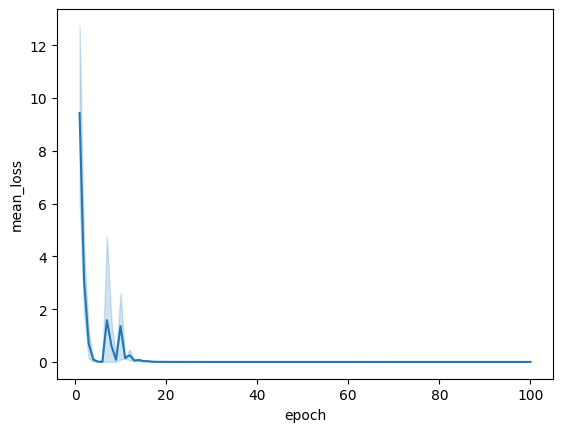

In [ ]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')


## Evaluate your model

You can use the `genai.generate_content` method and specify the name of your model to test your model performance.

In [ ]:
model = genai.GenerativeModel(model_name=f'tunedModels/{name}')

In [ ]:
result = model.generate_content('55')
result.text

'56'

In [ ]:
result = model.generate_content('123455')
result.text

'123456'

In [ ]:
result = model.generate_content('four')
result.text

'five'

In [ ]:
result = model.generate_content('quatre') # French 4
result.text                               # French 5 is "cinq"

'cinq'

In [ ]:
result = model.generate_content('III')    # Roman numeral 3
result.text                               # Roman numeral 4 is IV

'IV'

In [ ]:
result = model.generate_content('七')  # Japanese 7
result.text                            # Japanese 8 is 八!

'八'

It really seems to have picked up the task despite the limited examples, but "next" is a simple concept, see the [tuning guide](https://ai.google.dev/gemini-api/docs/model-tuning) for more guidance on improving performance.

## Update the description

You can update the description of your tuned model any time using the `genai.update_tuned_model` method.

In [ ]:
genai.update_tuned_model(f'tunedModels/{name}', {"description":"This is my model."});

In [ ]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model.description

'This is my model.'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [ ]:
genai.delete_tuned_model(f'tunedModels/{name}')

The model no longer exists:

In [ ]:
try:
  m = genai.get_tuned_model(f'tunedModels/{name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 GET https://generativelanguage.googleapis.com/v1beta/tunedModels/generate-num-8122?%24alt=json%3Benum-encoding%3Dint: Tuned model tunedModels/generate-num-8122 does not exist.
